# E-tivity 3: Clustering and Manifold Learning
### MSc in AI - CE6002 & CS5062 
Student Name: Michel Danjou

Student ID: 18263461

Use this notebook to complete Tasks 1 and 2 in E-tivity3.

# Import Python Modules

In [1]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn import cluster
from sklearn import preprocessing

# Task 1
## Load and scale the data

In the next cell we will be performing the following operations:
  * load the csv file into a panda dataset.
  * convert the data to a Numpy array
  * scale the data fro the Numpy array

In [3]:
# Load the data
df = pd.read_csv("loans_dataset_et3.csv")  
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,332.000000,332.000000,332.000000,332.000000,332.000000
mean,5201.093373,1495.508795,140.882530,341.710843,0.978916
std,4584.815491,1982.742932,75.544237,61.651497,0.143882
min,645.000000,0.000000,17.000000,60.000000,0.000000
25%,2912.750000,0.000000,100.000000,360.000000,1.000000
50%,3858.500000,1211.500000,128.000000,360.000000,1.000000
75%,5818.250000,2250.000000,162.000000,360.000000,1.000000
max,39999.000000,20000.000000,600.000000,480.000000,1.000000


In [4]:
# Convert data to np array
df_data = np.array(df.values, dtype=float)

# Scale the data
min_max_scaler = preprocessing.MinMaxScaler()
df_data = min_max_scaler.fit_transform(df_data)

#### Investigate the effect of scaling on the dataset
The graph below hightlights the fact that the scaling preserved the shape of the data. 

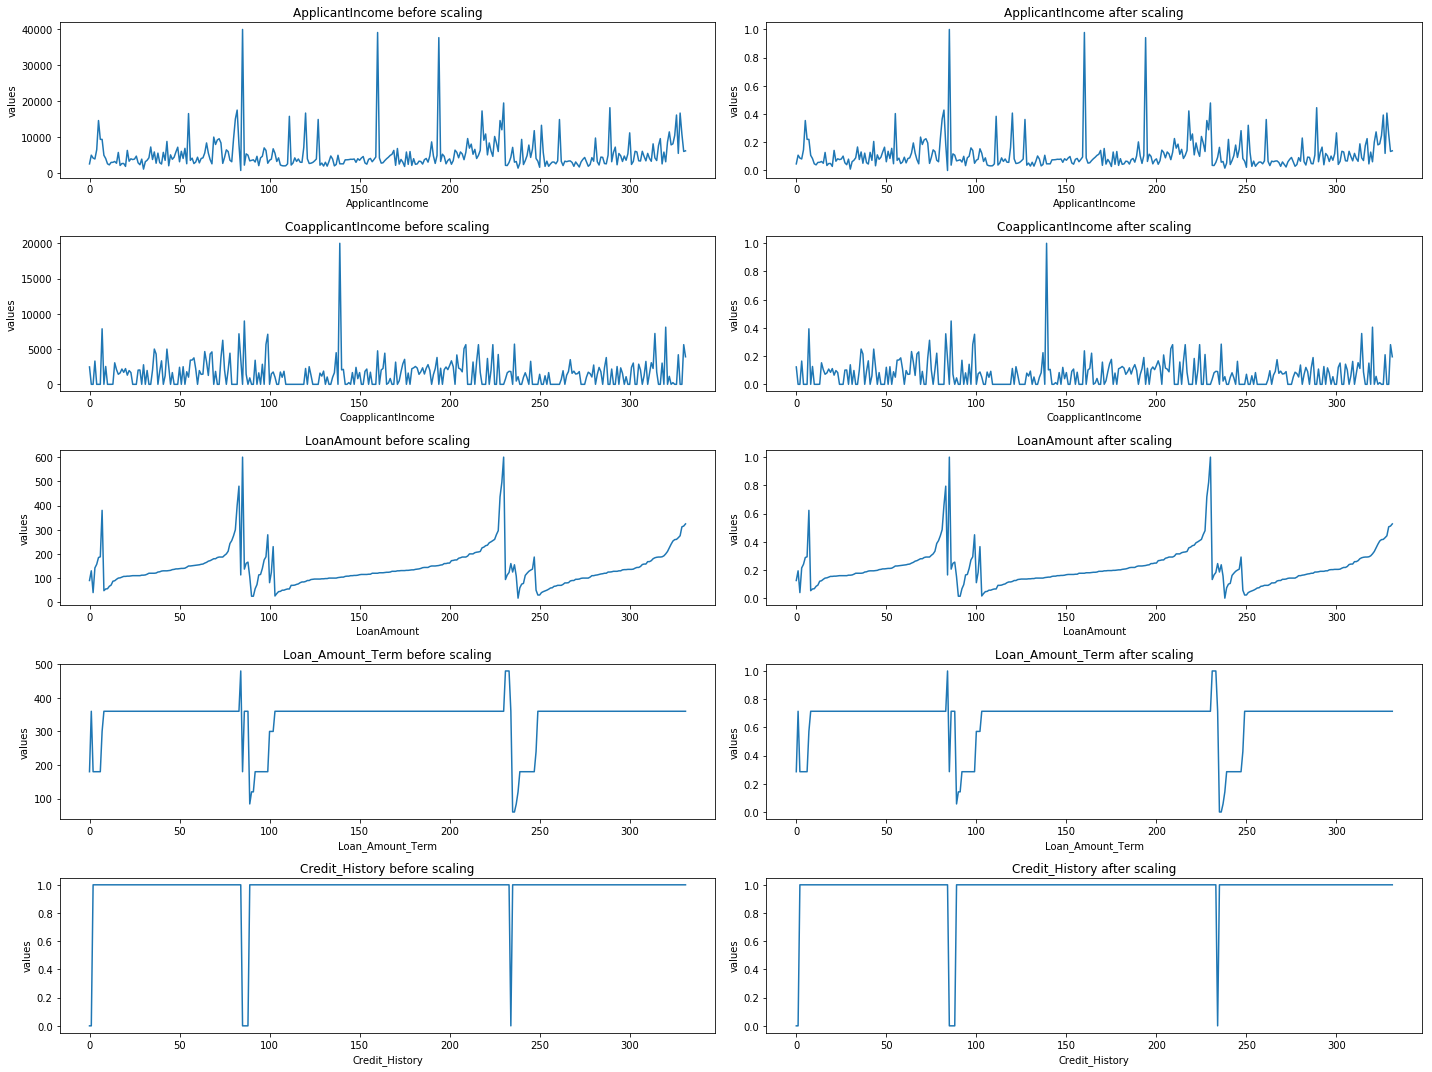

In [5]:
f, axs = plt.subplots(5, 2, figsize=(20, 15))
col_names = df.columns.values.tolist()

for i in range(5):
    
    plt.subplot(5, 2, 2*i+1)
    plt.plot(df.iloc[:,i])
    plt.xlabel(col_names[i])
    plt.ylabel('values')
    plt.title(col_names[i] + " before scaling")

    plt.subplot(5, 2, 2*i+2)
    plt.plot(df_data[:,i])
    plt.xlabel(col_names[i])
    plt.ylabel('values')
    plt.title(col_names[i] + " after scaling")

plt.tight_layout()
plt.show()

#### Search for correlated features by displaying the coorelation matrix
The correlation matrix below shows that the `LoanAmount` is correlated to the `ApplicantIncome` and to a lesser extend to the `CoapplicantIncome`

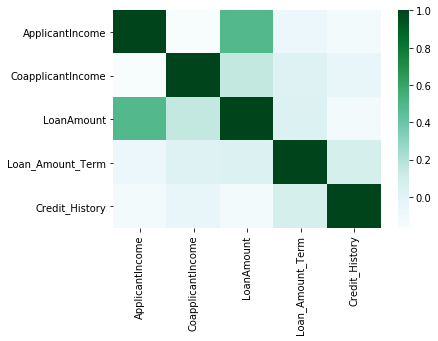

In [6]:
sns.heatmap(df.corr(), cmap='BuGn')

In [7]:
# Scatter plot
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    # plot the examples, i.e. the data points
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## KMeans clustering

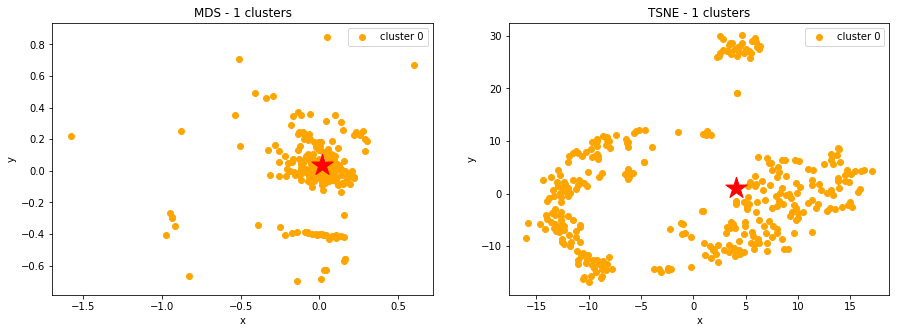

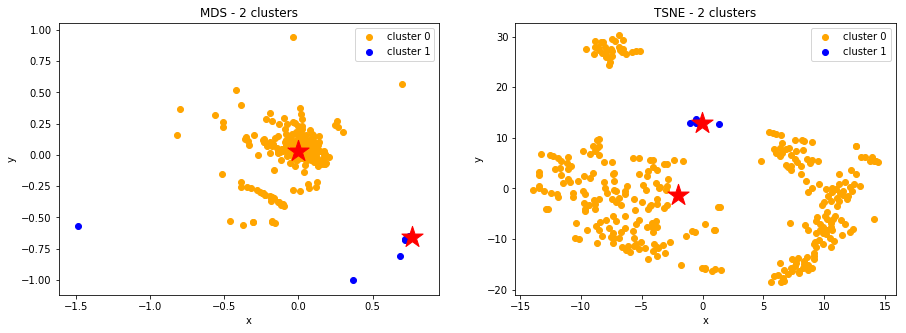

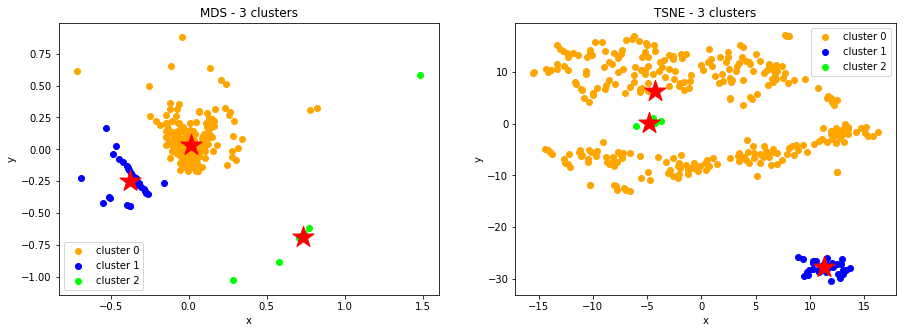

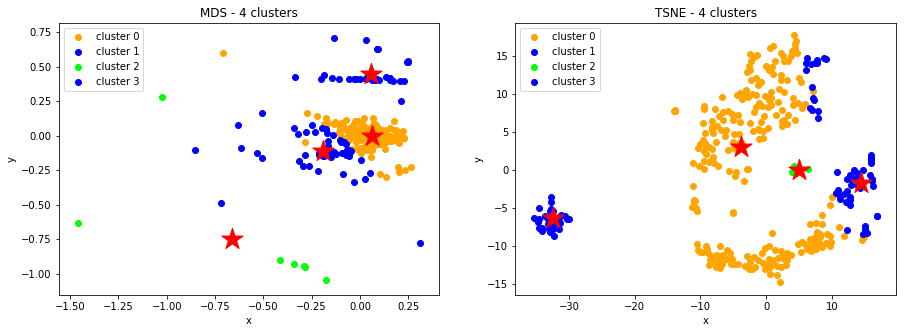

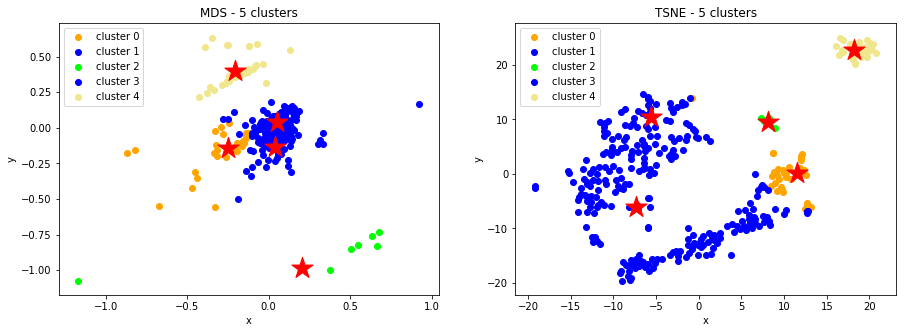

In [8]:
for k in range(1,6):
    # Run KMeans algorithm
    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(df_data)
    
    # Create new array composed of data + k centers 
    df_data_and_centers = np.r_[df_data,clustered_data_sklearn.cluster_centers_]

    f, axs = plt.subplots(1, 2, figsize=(15, 5))

    # MDS
    plt.subplot(1, 2, 1)
    XYcoordinates = manifold.MDS(n_components=2).fit_transform(df_data_and_centers)
    clustering_scatterplot(points=XYcoordinates[:-k,:], 
                           labels=clustered_data_sklearn.labels_, 
                           centers=XYcoordinates[-k:,:], 
                           title='MDS - ' + str(k) + ' clusters')

    # TSE
    plt.subplot(1, 2, 2)
    XYcoordinates = manifold.TSNE(n_components=2).fit_transform(df_data_and_centers)
    clustering_scatterplot(points=XYcoordinates[:-k,:], 
                           labels=clustered_data_sklearn.labels_,
                           centers=XYcoordinates[-k:,:], 
                           title='TSNE - ' + str(k) + ' clusters')

    plt.show()


In [9]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,cluster
0,2483,2466.0,90,180,0,2
1,4917,0.0,130,360,0,2
2,4106,0.0,40,180,1,4
3,3859,3300.0,142,180,1,4
4,6417,0.0,157,180,1,4


In [10]:
df.tail()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,cluster
327,5417,4196.0,267,360,1,3
328,16666,0.0,275,360,1,0
329,10750,0.0,312,360,1,0
330,5955,5625.0,315,360,1,3
331,6133,3906.0,324,360,1,3


In [12]:
#df.groupby('cluster').mean()
df.groupby('cluster').mean().sort_values(by=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], ascending=False)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
cluster,,,,,
0,13594.787879,501.393939,253.121212,360.000000,1.0
2,9153.857143,2098.142857,206.285714,308.571429,0.0
4,5146.966667,1297.126666,116.333333,161.600000,1.0
3,4363.444444,3865.428571,182.555556,360.000000,1.0
1,3943.477387,918.794573,110.477387,361.206030,1.0


We can see that 
  * the higher the sum of the `ApplicantIncome` and `CoapplicantIncome`, the higher the `LoanAmount`
  * the bank loans large amount of money even if there is no `Credit_History`
  * the loan values are small compared to the income
  * assuming that the loan terms are expressed in months, the terms are between the loan terms are at most 361 and at least 161. We assume that the terms are expressed in months.


# Task 2

In [13]:
print(161/12)

13.416666666666666
